[![View notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/examples/PySDM_examples/deJong_Azimi/box.ipynb)  
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=lab/tree/examples/PySDM_examples/deJong_Azimi/box.ipynb)    
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/deJong_Azimi/box.ipynb)

In [3]:
from typing import Optional

import numpy as np
from scipy.special import gamma
from matplotlib import pyplot
import xarray as xr

from open_atmos_jupyter_utils import show_plot

from PySDM_examples.deJong_Azimi import run_box

from PySDM import Formulae
from PySDM.physics import si, in_unit
from PySDM.dynamics.collisions.collision_kernels import SimpleGeometric, Golovin
from PySDM.dynamics.collisions.coalescence_efficiencies import ConstEc
from PySDM.initialisation.spectra import Gamma

In [4]:
class Settings0D:  # pylint: disable=too-many-instance-attributes,too-few-public-methods,missing-class-docstring
    def __init__(
        self,
        kernel: object,
        steps: list,
        radius_bins_edges: Optional[np.ndarray] = None,
    ):
        self.kernel = kernel
        self.n_sd = 2**12
        self.n_part = 100 / si.cm**3
        self.dv = 1 * si.m**3
        self.rho = 1000 * si.kg / si.m**3
        self.rhod = 1 * si.kg / si.m**3
        self.dt = 1 * si.s
        self.adaptive = True
        self.steps = steps
        self.coal_eff = ConstEc(Ec=1.0)
        self.spectrum = Gamma(
            norm_factor=self.n_part * self.dv, k=1.0, theta=1e5 * si.um**3
        )
        self.radius_bins_edges = radius_bins_edges if radius_bins_edges is not None else np.logspace(
            np.log10(8.0 * si.um), np.log10(5000 * si.um), num=64, endpoint=True
        )
        self.formulae = Formulae(terminal_velocity="PowerSeries")

In [130]:
def dvdlnr_gamma(m, N, theta, k=1):
    return N * m**(k-1) * np.exp(-m / theta) / theta**k / gamma(k)

## Golovin Kernel

In [6]:
settings_a = Settings0D(
    kernel = Golovin(b=5e3 * si.s),
    steps = [0, 60, 120]
)
res_a = run_box(settings_a)

In [161]:
ds1 = xr.open_dataset("box_single_gamma_golovin.nc")
ds2 = xr.open_dataset("box_double_gamma_golovin.nc")
ds3 = xr.open_dataset("box_three_gamma_golovin.nc")

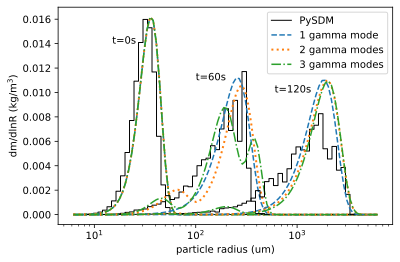

HTML(value="<a href='./box1.pdf' target='_blank'>./box1.pdf</a><br>")

In [165]:
fig, ax = pyplot.subplots(ncols=1, sharey=True, figsize=(6,4), dpi=200)

m_plt_ug = np.logspace(-3.0, 6.0, 100)
m_plt_kg = m_plt_ug * 1e-9
r1_plt = settings_a.formulae.trivia.radius(volume=m_plt_ug * si.ug / settings_a.rho)

colors = ['black','tab:blue','tab:orange','tab:green']
lss = ['--',':','-.']

for (j, step) in enumerate(settings_a.steps):
    line = ax.step(
        in_unit(res_a.radius_bins_left_edges, si.um),
        res_a.dv_dlnr[j] * settings_a.rho,
        label='PySDM' if j==0 else '_',
        color=colors[0],
        lw=1
    )
    a1_dmdlnr = dvdlnr_gamma(
        m_plt_kg,
        ds1["params"].where(ds1["time"] == step, drop=True)[0][0][0].item(),
        ds1["params"].where(ds1["time"] == step, drop=True)[1][0][0].item(),
        ds1["params"].where(ds1["time"] == step, drop=True)[2][0][0].item(),
    ) * 3 * m_plt_kg**2 * si.kg / si.m**3
    ax.plot(
        in_unit(r1_plt, si.um),
        in_unit(a1_dmdlnr, si.kg / si.m**3),
        ls = lss[0],
        label='1 gamma mode' if j==0 else '_',
        color=colors[1] #line[-1].get_color()
    )

    b1_dmdlnr = np.zeros_like(a1_dmdlnr)
    for k in ds2["dist"]:
        b1_dmdlnr += dvdlnr_gamma(
            m_plt_kg,
            ds2["params"].where(ds2["time"] == step, drop=True)[0][k][0].item(),
            ds2["params"].where(ds2["time"] == step, drop=True)[1][k][0].item(),
            ds2["params"].where(ds2["time"] == step, drop=True)[2][k][0].item()
        ) * 3 * m_plt_kg**2 * si.kg / si.m**3
    ax.plot(
        in_unit(r1_plt, si.um),
        b1_dmdlnr,
        ls=lss[1],
        lw=2,
        label='2 gamma modes' if j==0 else '_',
        color=colors[2], #line[-1].get_color()
    )

    c1_dmdlnr = np.zeros_like(a1_dmdlnr)
    for k in ds3["dist"]:
        c1_dmdlnr += dvdlnr_gamma(
            m_plt_kg,
            ds3["params"].where(ds3["time"] == step, drop=True)[0][k][0].item(),
            ds3["params"].where(ds3["time"] == step, drop=True)[1][k][0].item(),
            ds3["params"].where(ds3["time"] == step, drop=True)[2][k][0].item()
        ) * 3 * m_plt_kg**2 * si.kg / si.m**3
    ax.plot(
        in_unit(r1_plt, si.um),
        c1_dmdlnr,
        ls=lss[2],
        label='3 gamma modes' if j==0 else '_',
        color=colors[3] #line[-1].get_color(),
    )

ax.set_xscale("log")
ax.set_xlabel("particle radius (um)")
ax.set_ylabel("dm/dlnR (kg/m$^3$)")
ax.legend()
ax.annotate('t=0s', [15, 0.014])
ax.annotate('t=60s', [100, 0.011])
ax.annotate('t=120s', [600, 0.010])

show_plot('box1.pdf')

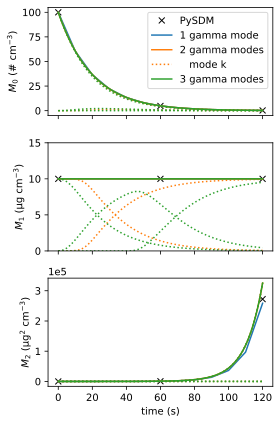

HTML(value="<a href='./box1_moments.pdf' target='_blank'>./box1_moments.pdf</a><br>")

In [152]:
fig, ax = pyplot.subplots(nrows=3, sharex=True, figsize=(4,6), dpi=200, tight_layout=True)
for i in range(3):
    ax[i].plot(
        np.asarray(settings_a.steps) * settings_a.dt,
        in_unit(
            res_a.moments[:, i] * settings_a.dv * settings_a.rho**i,
            si.ug**i / si.cm**3
        ),
        marker='x', linestyle='None', label='PySDM', color='k'
    )
    line = ax[i].plot(
        ds1["time"],
        in_unit(ds1["total_moments"].sel(order=i), si.ug**i / si.cm**3),
        label='1 gamma mode'
    )
    line = ax[i].plot(
        ds2["time"],
        in_unit(ds2["total_moments"].sel(order=i), si.ug**i / si.cm**3),
        label='2 gamma modes'
    )
    for k in ds2["dist"]:
        ax[i].plot(
            ds2["time"],
            in_unit(ds2["moments"].sel(order=i, dist=k), si.ug**i / si.cm**3),
            ':',
            linewidth=1.5, label='   mode k' if k==0 else '', color=line[-1].get_color()
        )
    line = ax[i].plot(
        ds3["time"],
        in_unit(ds3["total_moments"].sel(order=i), si.ug**i / si.cm**3),
        label='3 gamma modes'
    )
    for k in ds3["dist"]:
        ax[i].plot(
            ds3["time"],
            in_unit(ds3["moments"].sel(order=i, dist=k), si.ug**i / si.cm**3),
            ':',
            linewidth=1.5, label='_', color=line[-1].get_color()
        )

ax[0].legend()
ax[0].set_ylabel('$M_0$ (# cm$^{-3}$)')
ax[1].set_ylabel('$M_1$ (µg cm$^{-3}$)')
ax[1].set_ylim([0.0, 15.0])
ax[2].set_ylabel('$M_2$ (µg$^2$ cm$^{-3}$)')
ax[2].set_xlabel('time (s)')
ax[2].ticklabel_format(axis='y', style='sci', scilimits=(0,2))
pyplot.tight_layout()
show_plot('box1_moments.pdf')

## Geometric

In [186]:
#ds1 = xr.open_dataset("box_single_gamma_hydro.nc")
ds1 = xr.open_dataset("box_double_gamma_hydro.nc")
ds2 = xr.open_dataset("box_three_exp_hydro.nc")
ds3 = xr.open_dataset("box_three_gamma_hydro.nc")

In [187]:
d2M2 = 2 * ds2["params"].sel(order = 0) * ds2["params"].sel(order = 1)**2
d2M2_tot = d2M2.sum('dist')

In [188]:
settings_b = Settings0D(
    kernel = SimpleGeometric(1e6 * np.pi),
    steps = [0, 220],
    radius_bins_edges = np.logspace(
        np.log10(8.0 * si.um), np.log10(10000 * si.um), num=64, endpoint=True
    ),
)
settings_b.dt = 0.5
settings_b.n_sd = 2**15
settings_b.steps = [0, int(120/settings_b.dt), int(220/settings_b.dt)]
res_b = run_box(settings_b)

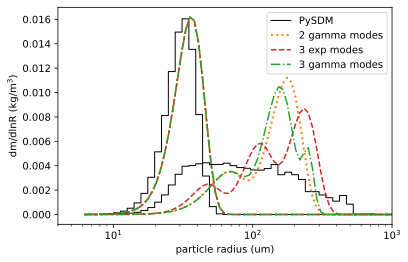

HTML(value="<a href='./box2.pdf' target='_blank'>./box2.pdf</a><br>")

In [189]:
fig, ax = pyplot.subplots(ncols=1, sharey=True, figsize=(6,4), dpi=200)

colors = ['black','tab:orange','tab:red','tab:green']
lss = [':','--','-.']

m_plt_ug = np.logspace(-3.0, 6.0, 100)
m_plt_kg = m_plt_ug * 1e-9

r2_plt = settings_b.formulae.trivia.radius(volume=m_plt_ug * si.ug / settings_b.rho)

for (j, step) in enumerate(settings_b.steps):
    if j == 1:
        continue
    line = ax.step(
        in_unit(res_b.radius_bins_left_edges, si.um),
        res_b.dv_dlnr[j] * settings_b.rho,
        label='PySDM' if j==0 else '_',
        color=colors[0],
        lw=1,
    )
    step = step * settings_b.dt

    a2_dmdlnr = np.zeros_like(m_plt_kg)
    for k in ds1["dist"]:
        a2_dmdlnr += dvdlnr_gamma(
            m_plt_kg,
            ds1["params"].where(ds1["time"] == step, drop=True)[0][k][0].item(),
            ds1["params"].where(ds1["time"] == step, drop=True)[1][k][0].item(),
            ds1["params"].where(ds1["time"] == step, drop=True)[2][k][0].item(),
        ) * 3 * m_plt_kg**2 * si.kg / si.m**3
    ax.plot(
        in_unit(r2_plt, si.um),
        in_unit(a2_dmdlnr, si.kg / si.m**3),
        ls=lss[0],
        label='2 gamma modes' if j==0 else '_',
        color=colors[1],
        lw=2
    )

    b2_dmdlnr = np.zeros_like(a2_dmdlnr)
    for k in ds2["dist"]:
        b2_dmdlnr += dvdlnr_gamma(
            m_plt_kg,
            ds2["params"].where(ds2["time"] == step, drop=True)[0][k][0].item(),
            ds2["params"].where(ds2["time"] == step, drop=True)[1][k][0].item(),
            #ds2["params"].where(ds2["time"] == step, drop=True)[2][k][0].item()
        ) * 3 * m_plt_kg**2 * si.kg / si.m**3
    ax.plot(
        in_unit(r2_plt, si.um),
        b2_dmdlnr,
        ls=lss[1],
        label='3 exp modes' if j==0 else '_',
        color=colors[2],
    )

    c2_dmdlnr = np.zeros_like(a2_dmdlnr)
    for k in ds3["dist"]:
        c2_dmdlnr += dvdlnr_gamma(
            m_plt_kg,
            ds3["params"].where(ds3["time"] == step, drop=True)[0][k][0].item(),
            ds3["params"].where(ds3["time"] == step, drop=True)[1][k][0].item(),
            ds3["params"].where(ds3["time"] == step, drop=True)[2][k][0].item()
        ) * 3 * m_plt_kg**2 * si.kg / si.m**3
    ax.plot(
        in_unit(r1_plt, si.um),
        c2_dmdlnr,
        label='3 gamma modes' if j==0 else '_',
        color=colors[3],
        ls=lss[2]
    )

ax.set_xscale("log")
ax.set_xlim([4, 1000])
ax.set_xlabel("particle radius (um)")
ax.set_ylabel("dm/dlnR (kg/m$^3$)")
ax.legend()
show_plot('box2.pdf')

In [195]:
settings_c = Settings0D(
    kernel = settings_b.kernel,
    steps = np.linspace(0, 220, 23, dtype=int),
    radius_bins_edges = settings_b.radius_bins_edges,
)
settings_c.n_sd = settings_b.n_sd
res_c = run_box(settings_c)

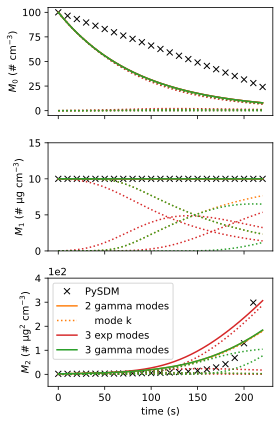

HTML(value="<a href='./box2_moments.pdf' target='_blank'>./box2_moments.pdf</a><br>")

In [197]:
fig, ax = pyplot.subplots(nrows=3, sharex=True, figsize=(4,6), dpi=200, tight_layout=True)
for i in range(3):
    ax[i].plot(
        np.asarray(settings_c.steps) * settings_c.dt,
        in_unit(
            res_c.moments[:, i] * settings_c.dv * settings_c.rho**i,
            si.ug**i / si.cm**3
        ),
        marker='x',
        linestyle='None',
        label='PySDM',
        color='k'
    )
    line = ax[i].plot(
        ds1["time"],
        in_unit(ds1["total_moments"].sel(order=i), si.ug**i / si.cm**3),
        color=colors[1],
        label='2 gamma modes'
    )
    for k in ds1["dist"]:
        ax[i].plot(
            ds1["time"],
            in_unit(ds1["moments"].sel(order=i, dist=k), si.ug**i / si.cm**3),
            ':',
            linewidth=1.5, label='   mode k' if k==0 else '', color=line[-1].get_color()
        )
    if i < 2:
        line = ax[i].plot(
            ds2["time"],
            in_unit(ds2["total_moments"].sel(order=i), si.ug**i / si.cm**3),
            color = colors[2],
            label='3 exp modes'
        )
        for k in ds2["dist"]:
            ax[i].plot(
                ds2["time"],
                in_unit(ds2["moments"].sel(order=i, dist=k), si.ug**i / si.cm**3),
                ':',
                linewidth=1.5, color=line[-1].get_color()
            )
    else:
        line = ax[i].plot(
            ds2["time"],
            in_unit(d2M2_tot, si.ug**i / si.cm**3),
            color = colors[2],
            label='3 exp modes'
        )
        for k in ds2["dist"]:
            ax[i].plot(
                ds2["time"],
                in_unit(d2M2.sel(dist=k), si.ug**i / si.cm**3),
                ':',
                linewidth=1.5, color=line[-1].get_color()
            )
   
    line = ax[i].plot(
        ds3["time"],
        in_unit(ds3["total_moments"].sel(order=i), si.ug**i / si.cm**3),
        color = colors[3],
        label='3 gamma modes'
    )
    for k in ds3["dist"]:
        ax[i].plot(
            ds3["time"],
            in_unit(ds3["moments"].sel(order=i, dist=k), si.ug**i / si.cm**3),
            ':',
            linewidth=1.5, color=line[-1].get_color()
        )

ax[2].legend()
ax[0].set_ylabel('$M_0$ (# cm$^{-3}$)')
ax[1].set_ylabel('$M_1$ (# µg cm$^{-3}$)')
ax[1].set_ylim([0.0, 15.0])
ax[2].set_ylim([-50, 400])
ax[2].set_ylabel('$M_2$ (# µg$^2$ cm$^{-3}$)')
ax[2].set_xlabel('time (s)')
ax[2].ticklabel_format(axis='y', style='sci', scilimits=(0,2))

show_plot('box2_moments.pdf')